# WOA7015 Advance Machine Learning
## Alternative Assessment: Skin Cancer Classification

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import itertools
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Activation, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input, BatchNormalization, ReLU, LeakyReLU, PReLU, Add, DepthwiseConv2D, concatenate, AvgPool2D
from keras import backend as K
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, Model

from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, ResNet50
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

#### Functions

In [ ]:
# Function to plot model's training & validation loss and accuracy
def plot_history(history):
    # Extract metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Function to print model's confusion matrix and classification report
def evaluate_model(model, x_test, y_test):
    class_names = ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions',
               'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma']

    # Predict on the test set
    y_pred_probs = model.predict(x_test)  # Get probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
    y_true = np.argmax(y_test, axis=1)  # True labels

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # False Negative Rate (FNR)
    cm = confusion_matrix(y_true, y_pred)
    fnr_per_class = cm.sum(axis=1) - np.diag(cm)  # FN per class
    fnr = np.sum(fnr_per_class) / np.sum(cm)     # Overall FNR

    # AUC
    auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC: {auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Exploratory Data Analysis (EDA)

In [ ]:
# Resize images, just run once will do
base_skin_dir = r'C:\Users\PC\Desktop\MAI Y1S1\Advanced Machine Learning\Alternative Assessment\input'
output_base_dir = r'C:\Users\PC\Desktop\MAI Y1S1\Advanced Machine Learning\Alternative Assessment\input\resized_dataset'
os.makedirs(output_base_dir, exist_ok=True)

# Process each folder separately
folders = [os.path.join(base_skin_dir, folder) for folder in os.listdir(base_skin_dir) if os.path.isdir(os.path.join(base_skin_dir, folder))]

# Resize images folder by folder
for folder in folders:
    folder_name = os.path.basename(folder)  # Name of the current folder
    output_folder = os.path.join(output_base_dir, folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Get all image paths in the current folder
    image_paths = glob(os.path.join(folder, '*.jpg'))

    # Resize and save images
    for img_path in tqdm(image_paths, desc=f"Processing folder: {folder_name}"):
        img_id = os.path.splitext(os.path.basename(img_path))[0]
        output_path = os.path.join(output_folder, f"{img_id}.jpg")

        # Read, resize, and save image
        img = cv2.imread(img_path)
        resized_img = cv2.resize(img, (100, 75))  # Resize to target size
        cv2.imwrite(output_path, resized_img)

print("Image resizing completed and saved in the resized dataset directory.")

In [ ]:
base_skin_dir = '/content/drive/MyDrive/input'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/input/HAM10000_images_p...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/input/HAM10000_images_p...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/input/HAM10000_images_p...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/input/HAM10000_images_p...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/input/HAM10000_images_p...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/input/HAM10000_images_p...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/input/HAM10000_images_p...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/input/HAM10000_images_p...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/drive/MyDrive/input/HAM10000_images_p...,Actinic keratoses,0


In [ ]:
skin_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

<ipython-input-137-8b8ec19cc3cf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


In [ ]:
skin_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [ ]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


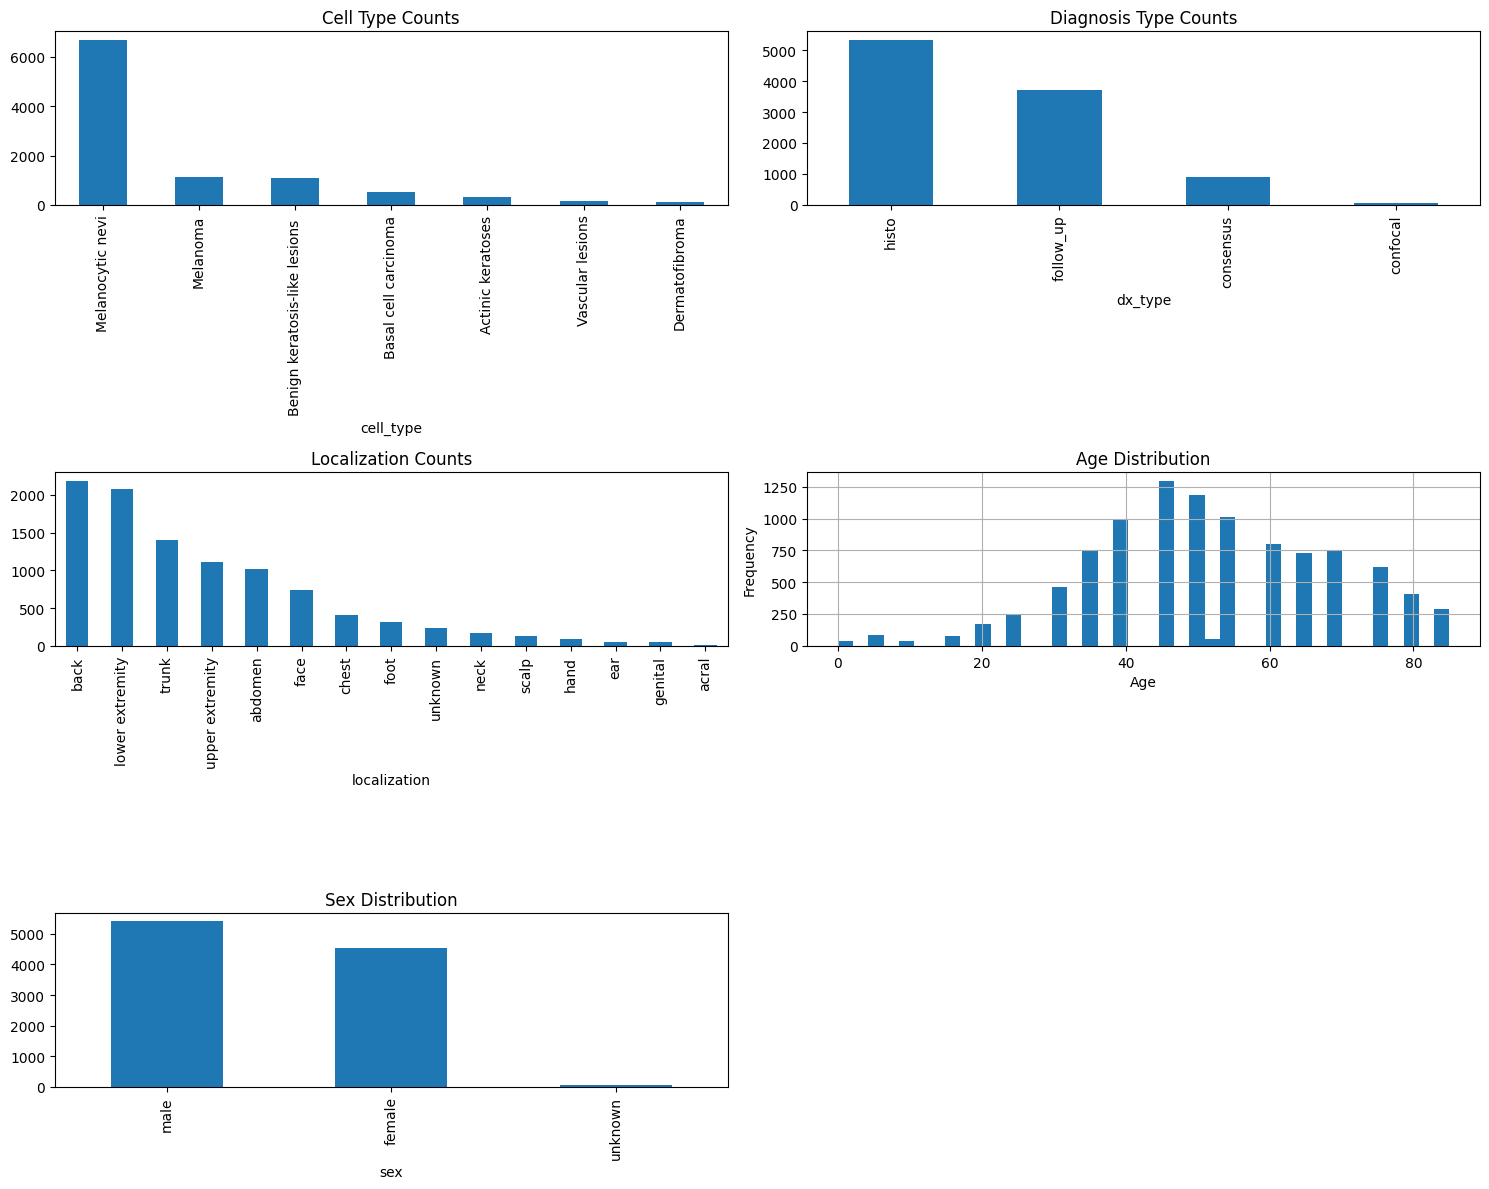

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

skin_df['cell_type'].value_counts().plot(kind='bar', ax=axes[0], title='Cell Type Counts')
skin_df['dx_type'].value_counts().plot(kind='bar', ax=axes[1], title='Diagnosis Type Counts')
skin_df['localization'].value_counts().plot(kind='bar', ax=axes[2], title='Localization Counts')
skin_df['age'].hist(bins=40, ax=axes[3])
axes[3].set_title('Age Distribution')
axes[3].set_xlabel('Age')
axes[3].set_ylabel('Frequency')
skin_df['sex'].value_counts().plot(kind='bar', ax=axes[4], title='Sex Distribution')
fig.delaxes(axes[5])
plt.tight_layout()

plt.show()

In [ ]:
skin_df['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,6705
Melanoma,1113
Benign keratosis-like lesions,1099
Basal cell carcinoma,514
Actinic keratoses,327
Vascular lesions,142
Dermatofibroma,115


### Data Preparation and Preprocessing

In [ ]:
# Copy compressed dataset to runtime
!cp /content/drive/MyDrive/input.zip /content/input.zip

# Extract in runtime
!unzip /content/input.zip -d /content/input

Streaming output truncated to the last 5000 lines.
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029322.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029323.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029324.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/input/HAM10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/input/HAM10000_im

In [ ]:
base_skin_dir = '/content/input'
skin_df['path'] = skin_df['path'].str.replace('/content/drive/MyDrive', '/content')

# Load image
skin_df['image'] = skin_df['path'].progress_map(lambda x: np.asarray(Image.open(x)))

100%|██████████| 10015/10015 [00:03<00:00, 3226.66it/s]


In [ ]:
# Already resized from 600x450 to 100x75
# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

# grayscale (significant drop in accuracy)
# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).convert('L').resize((100, 75))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/input/HAM10000_images_part_1/ISIC_002...,Benign keratosis-like lesions,2,"[[[192, 152, 202], [194, 155, 202], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/input/HAM10000_images_part_1/ISIC_002...,Benign keratosis-like lesions,2,"[[[24, 13, 27], [25, 14, 30], [25, 12, 30], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/input/HAM10000_images_part_1/ISIC_002...,Benign keratosis-like lesions,2,"[[[176, 128, 142], [188, 137, 152], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/input/HAM10000_images_part_1/ISIC_002...,Benign keratosis-like lesions,2,"[[[24, 12, 26], [30, 14, 27], [41, 19, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/input/HAM10000_images_part_2/ISIC_003...,Benign keratosis-like lesions,2,"[[[130, 90, 116], [145, 105, 131], [156, 112, ..."


In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(75, 100, 3)",10015


In [ ]:
features = skin_df.drop(columns=['cell_type_idx'], axis=1)
target = skin_df['cell_type_idx']

In [ ]:
# Train-Valid-Test Split

# Split into train, validation, and test
x_train_o, x_test_o, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42, stratify=target)
x_train_o, x_validate_o, y_train, y_validate = train_test_split(x_train_o, y_train, test_size=0.15, random_state=42, stratify=y_train)

In [ ]:
# Compute class weights to address class imbalance issue since SMOTE is not suitable
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format for TensorFlow
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print('Class Weights:', class_weight_dict)

Class Weights: {0: 4.37953995157385, 1: 2.778417818740399, 2: 1.3017272400143938, 3: 12.452667814113598, 4: 0.21337147575793322, 5: 1.2855366027007817, 6: 10.133053221288515}


In [ ]:
# Standardisation
# Convert 'image' column to NumPy arrays
x_train = np.asarray(x_train_o['image'].tolist())
x_validate = np.asarray(x_validate_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

# Compute mean and std from training set
train_mean = np.mean(x_train)
train_std = np.std(x_train)

# Normalize all sets using training statistics
x_train = (x_train - train_mean) / train_std
x_validate = (x_validate - train_mean) / train_std
x_test = (x_test - train_mean) / train_std

In [ ]:
# One-hot encoding on the labels
y_train = to_categorical(y_train, num_classes=7)
y_validate = to_categorical(y_validate, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

print(f"y_train shape: {y_train.shape}")
print(f"y_validate shape: {y_validate.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (7235, 7)
y_validate shape: (1277, 7)
y_test shape: (1503, 7)


In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
# x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
# x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
# x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

### Data Augmentation

In [ ]:
batch_size = 32
num_classes = 7
input_tensor = tf.random.normal((batch_size, 75, 100, 3))  # Example input

# Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Validation Data Generator (No Augmentation)
validate_datagen = ImageDataGenerator()

# Create Data Generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
validate_generator = validate_datagen.flow(x_validate, y_validate, batch_size=batch_size, shuffle=False)

### Model Building & Training 1

1. Baseline Model - Customized CNN
2. Ensemble Model - EfficientNetB0 + DenseNet121 (pretrained and partially pretrained)
3. UNet with Classifier - ResNet50 as the encoder (partially pretrained)

In [ ]:
# Baseline CNN
class BaselineCNN(Model):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.features = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2))
        ])
        self.flatten = layers.Flatten()
        self.classifier = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        x = self.features(inputs)
        x = self.flatten(x)
        return self.classifier(x)


# Partially pretrained Ensemble Model
class EnsembleModel_P(Model):
    def __init__(self, num_classes):
        super(EnsembleModel_P, self).__init__()

        # Pretrained EfficientNetB0
        self.efficientnet = EfficientNetB0(include_top=False, pooling='avg', input_shape=(75, 100, 3), weights='imagenet')
        for layer in self.efficientnet.layers[:18]:  # Freeze up to Block 1, ends at layer 17
            layer.trainable = False

        # for i, layer in enumerate(self.efficientnet.layers):
        #     print(f"Layer {i}: {layer.name}")

        # Pretrained DenseNet121
        self.densenet = DenseNet121(include_top=False, pooling='avg', input_shape=(75, 100, 3), weights='imagenet')
        for layer in self.densenet.layers[:49]:  # Freeze up to Dense Block 1, ends at layer 39
            layer.trainable = False

        # for i, layer in enumerate(self.densenet.layers):
        #     print(f"Layer {i}: {layer.name}")

        # Classifier layers
        self.classifier = tf.keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        # Forward pass through the encoders
        x1 = self.efficientnet(inputs)
        x2 = self.densenet(inputs)

        # Concatenate features and classify
        x = tf.concat([x1, x2], axis=-1)
        return self.classifier(x)


# Pretrained Ensemble Model
class EnsembleModel_F(Model):
    def __init__(self, num_classes):
        super(EnsembleModel_F, self).__init__()

        # Fully trainable EfficientNetB0
        self.efficientnet = EfficientNetB0(include_top=False, pooling='avg', input_shape=(75, 100, 3), weights='imagenet')
        for layer in self.efficientnet.layers:
            layer.trainable = False  # Freeze all

        # Fully trainable DenseNet121
        self.densenet = DenseNet121(include_top=False, pooling='avg', input_shape=(75, 100, 3), weights='imagenet')
        for layer in self.densenet.layers:
            layer.trainable = False  # Freeze all

        # Classifier layers
        self.classifier = tf.keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        # Forward pass through the encoders
        x1 = self.efficientnet(inputs)
        x2 = self.densenet(inputs)

        # Concatenate features and classify
        x = tf.concat([x1, x2], axis=-1)
        return self.classifier(x)


# UNet Model with ResNet Encoder (Classification)
class UNet(Model):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        # Pretrained ResNet50 as encoder
        resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(75, 100, 3))
        self.encoder = tf.keras.Model(inputs=resnet.input, outputs=[resnet.get_layer(name).output for name in [
            'conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out'
        ]])

        for layer in self.encoder.layers[:39]:  # Freeze up to conv2_block3_out, ends at layer 38
            layer.trainable = False

        # Decoder layers
        self.decoders = [
            layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')
        ]

        # Global pooling and classification head
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Encoder forward pass
        features = self.encoder(inputs)

        # Decoder with skip connections
        x = features[-1]  # Start from the deepest feature map
        for i in range(len(features) - 2, -1, -1):
            x = self.decoders[len(features) - 2 - i](x)
            x = tf.image.resize(x, tf.shape(features[i])[1:3])  # Resize to match encoder feature map
            x = layers.Concatenate()([x, features[i]])

        # Global pooling and classification
        x = self.global_pool(x)
        return self.dense(x)


# Baseline CNN
baseline_cnn = BaselineCNN(num_classes)
baseline_cnn_output = baseline_cnn(input_tensor)

# Partially pretrained Ensemble Model
ensemble_p = EnsembleModel_P(num_classes)
ensemble_p_output = ensemble_p(input_tensor)

# Pretrained Ensemble Model
ensemble_f = EnsembleModel_F(num_classes)
ensemble_f_output = ensemble_f(input_tensor)

# UNet
unet = UNet(num_classes)
unet_output = unet(input_tensor)

print(baseline_cnn_output.shape, ensemble_p_output.shape, ensemble_f_output.shape, unet_output.shape)

(32, 7) (32, 7) (32, 7) (32, 7)


In [ ]:
print(baseline_cnn.summary())
print(ensemble_p.summary())
print(ensemble_f.summary())
print(unet.summary())

Model: "baseline_cnn_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_68 (Sequential)           │ (32, 18, 25, 64)            │          19,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (32, 28800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_69 (Sequential)           │ (32, 7)                     │       7,374,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,394,247 (28.21 MB)

 Trainable params: 7,394,247 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "ensemble_model_p_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_70 (Sequential)           │ (32, 7)                     │       1,183,751 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,270,826 (46.81 MB)

 Trainable params: 11,798,203 (45.01 MB)

 Non-trainable params: 472,623 (1.80 MB)

None


Model: "ensemble_model_f_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_71 (Sequential)           │ (32, 7)                     │       1,183,751 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,270,826 (46.81 MB)

 Trainable params: 1,183,751 (4.52 MB)

 Non-trainable params: 11,087,075 (42.29 MB)

None


Model: "u_net_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_73 (Functional)           │ [(None, 38, 50, 64), (None, │      23,587,712 │
│                                      │ 19, 25, 256), (None, 10,    │                 │
│                                      │ 13, 512), (None, 5, 7,      │                 │
│                                      │ 1024), (None, 3, 4, 2048)]  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (32, 6, 8, 512)             │       9,437,696 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (32, 10, 14, 256)           │       3,539,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (32, 20, 26, 128)           │         884,864 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (32, 38, 50, 64)            │         221,248 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (32, 128)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (32, 7)                     │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,671,623 (143.71 MB)

 Trainable params: 37,391,687 (142.64 MB)

 Non-trainable params: 279,936 (1.07 MB)

None


In [ ]:
epochs = 10

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6392 - loss: 1.5040 - val_accuracy: 0.6969 - val_loss: 0.8625
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.6820 - loss: 0.8710 - val_accuracy: 0.7048 - val_loss: 0.8260
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7110 - loss: 0.7919 - val_accuracy: 0.7416 - val_loss: 0.7691
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.7243 - loss: 0.7532 - val_accuracy: 0.7291 - val_loss: 0.7591
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.7425 - loss: 0.7177 - val_accuracy: 0.7408 - val_loss: 0.7218
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7319 - loss: 0.7170 - val_accuracy: 0.7447 - val_loss: 0.7220
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7515 - loss: 0.6585 - val_accuracy: 0.7541 - val_loss: 0.7058
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.7475 - loss: 0.6716 - 

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7422 - loss: 0.7021
Test Loss: 0.6815, Test Accuracy: 0.7572


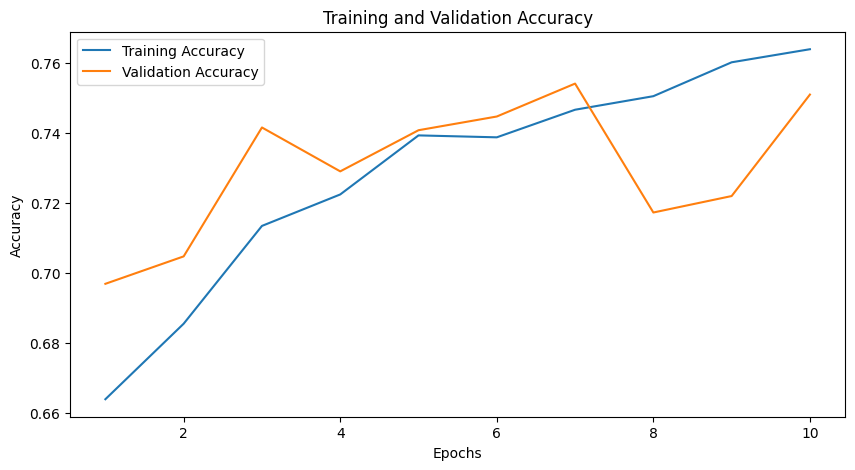

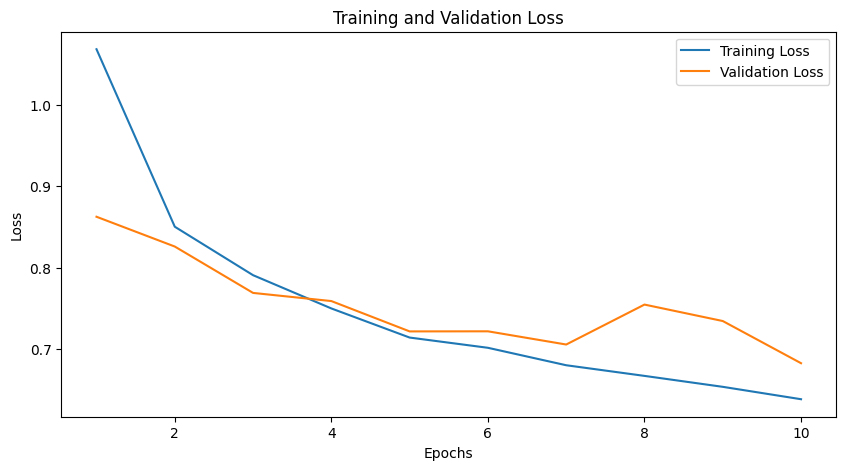

In [ ]:
# BaselineCNN
model1 = BaselineCNN(num_classes=7)

# Compile the Model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

# Train the model
model1_history = model1.fit(train_generator,
                            validation_data=validate_generator,
                            epochs=epochs,
                            class_weight=class_weight_dict)

# Save the Trained Model
model1.save("baseline_cnn.h5")

# Evaluate on Test Data
test_loss, test_accuracy = model1.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(model1_history)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 187s 332ms/step - accuracy: 0.6329 - loss: 2.4698 - val_accuracy: 0.6727 - val_loss: 0.9109
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.6875 - loss: 0.8694 - val_accuracy: 0.7118 - val_loss: 0.7803
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7044 - loss: 0.8013 - val_accuracy: 0.7384 - val_loss: 0.7404
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7196 - loss: 0.7426 - val_accuracy: 0.7416 - val_loss: 0.7470
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7344 - loss: 0.7146 - val_accuracy: 0.7416 - val_loss: 0.7523
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7448 - loss: 0.6977 - val_accuracy: 0.7408 - val_loss: 0.7131
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.7492 - loss: 0.6765 - val_accuracy: 0.7627 - val_loss: 0.6922
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7537 - loss: 0.6590 

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.7462 - loss: 0.6548
Test Loss: 0.6528, Test Accuracy: 0.7498


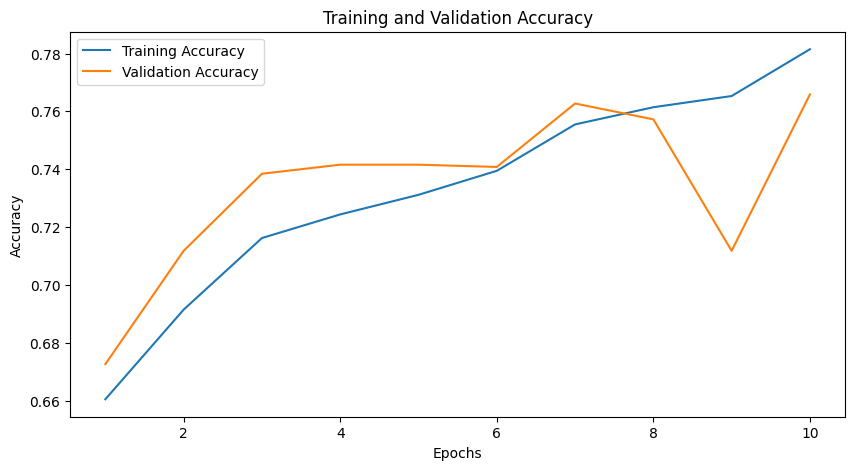

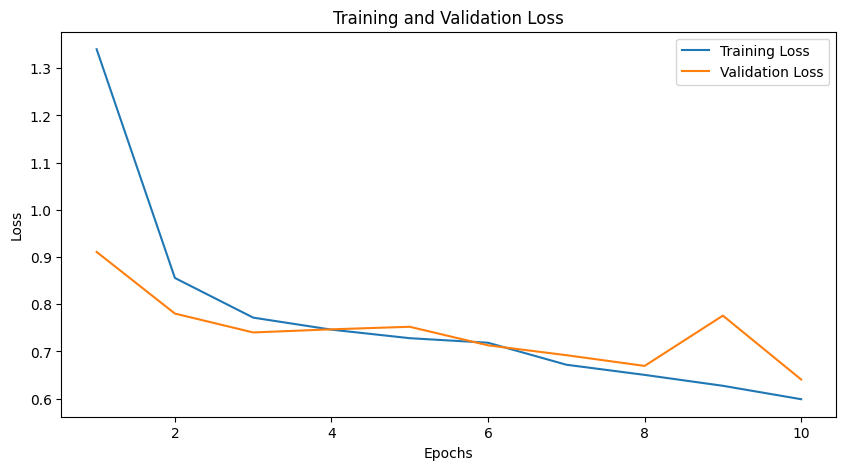

In [ ]:
model2 = EnsembleModel_P(num_classes)

# Compile the Model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

# Train the model
model2_history = model2.fit(train_generator,
                            validation_data=validate_generator,
                            epochs=epochs,
                            class_weight=class_weight_dict)

# Save the Trained Model
model2.save("ensemble_model_p.h5")

# Evaluate on Test Data
test_loss, test_accuracy = model2.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(model2_history)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 202ms/step - accuracy: 0.6703 - loss: 1.2670 - val_accuracy: 0.7369 - val_loss: 0.7448
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7395 - loss: 0.7061 - val_accuracy: 0.7259 - val_loss: 0.7634
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7429 - loss: 0.6903 - val_accuracy: 0.7408 - val_loss: 0.7146
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7586 - loss: 0.6497 - val_accuracy: 0.7596 - val_loss: 0.7093
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7614 - loss: 0.6237 - val_accuracy: 0.7651 - val_loss: 0.6759
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7589 - loss: 0.6453 - val_accuracy: 0.7525 - val_loss: 0.6754
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7608 - loss: 0.6240 - val_accuracy: 0.7588 - val_loss: 0.7033
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7761 - loss: 0.5927 - val_accura

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.7471 - loss: 0.6835
Test Loss: 0.7116, Test Accuracy: 0.7332


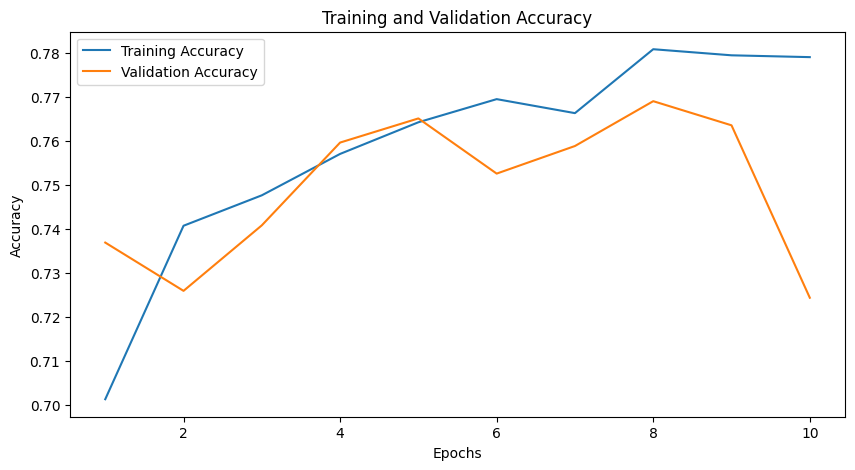

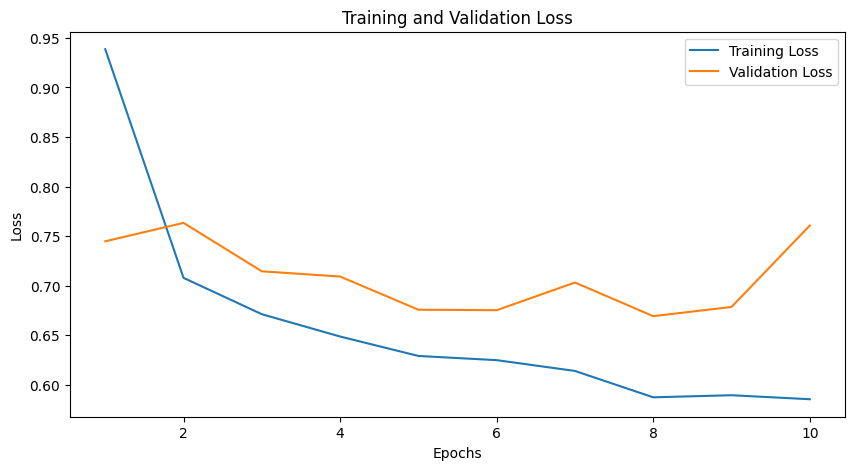

In [ ]:
model3 = EnsembleModel_F(num_classes)

# Compile the Model
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

# Train the model
model3_history = model3.fit(train_generator,
                            validation_data=validate_generator,
                            epochs=epochs,
                            class_weight=class_weight_dict)

# Save the Trained Model
model3.save("ensemble_model_f.h5")

# Evaluate on Test Data
test_loss, test_accuracy = model3.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(model3_history)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 154ms/step - accuracy: 0.6531 - loss: 1.5902 - val_accuracy: 0.6695 - val_loss: 1.1220
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6653 - loss: 1.1595 - val_accuracy: 0.6695 - val_loss: 1.1216
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.6739 - loss: 1.1209 - val_accuracy: 0.6695 - val_loss: 1.1387
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.6671 - loss: 1.1457 - val_accuracy: 0.6711 - val_loss: 1.1049
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6699 - loss: 1.1148 - val_accuracy: 0.6695 - val_loss: 1.0930
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6685 - loss: 1.1060 - val_accuracy: 0.6695 - val_loss: 1.0838
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6595 - loss: 1.1325 - val_accuracy: 0.6735 - val_loss: 1.0867
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.6706 - loss: 1.0932 -

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6740 - loss: 1.0498
Test Loss: 1.0631, Test Accuracy: 0.6680


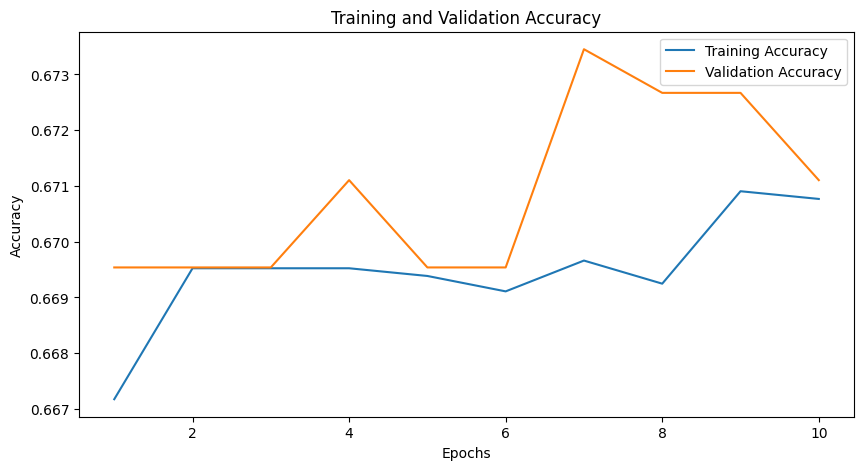

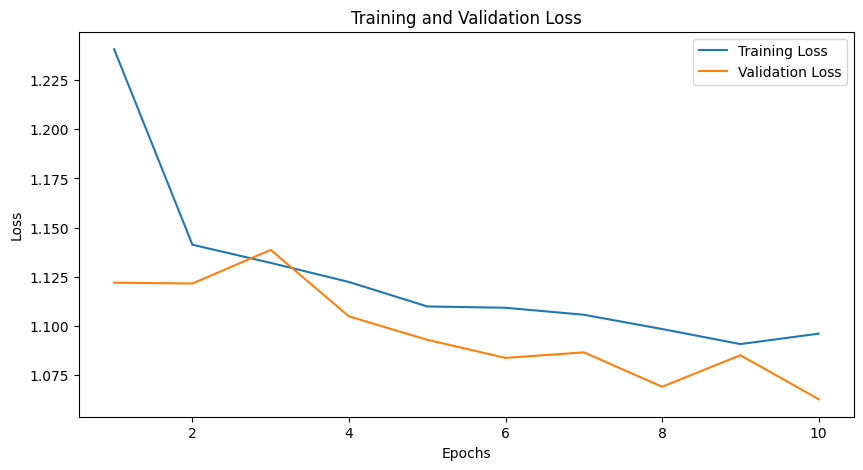

In [ ]:
model4 = UNet(num_classes)

# Compile the Model
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

# Train the model
model4_history = model4.fit(train_generator,
                            validation_data=validate_generator,
                            epochs=epochs,
                            class_weight=class_weight_dict)

# Save the Trained Model
model4.save("unet.h5")

# Evaluate on Test Data
test_loss, test_accuracy = model4.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(model4_history)

In the previous section, we utilized the model architectures of EfficientNetB0, DenseNet121, and ResNet50 with pretrained features from the top layers (e.g., edges, textures) to retain the valuable features learned from ImageNet. This allowed us to leverage transfer learning effectively. The accuracies achieved were in the range of 65-75%, which is expected as training large neural networks typically requires longer training times and higher epochs to converge effectively.

### Model Building & Training 2

In this section, we will not leverage the pretrained weights of the models. Instead, we will focus solely on utilizing their intricate architectures, allowing the networks to learn from scratch. This approach enables the models to fine-tune all layers to better capture the unique features of our dataset. By doing so, we aim to evaluate how training the models entirely on our dataset impacts their accuracy and overall performance.

1. Ensemble Model - EfficientNetB0 + DenseNet121 (without pretrained weights)
2. UNet with Classifier - ResNet50 (without pretrained weights) as the encoder

In [ ]:
class EnsembleModel_S(Model):
    def __init__(self, num_classes):
        super(EnsembleModel_S, self).__init__()
        self.efficientnet = EfficientNetB0(include_top=False, pooling='avg', input_shape=(75, 100, 3))
        self.densenet = DenseNet121(include_top=False, pooling='avg', input_shape=(75, 100, 3))

        self.classifier = tf.keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        x1 = self.efficientnet(inputs)
        x2 = self.densenet(inputs)
        x = tf.concat([x1, x2], axis=-1)
        return self.classifier(x)


class UNet_S(Model):
    def __init__(self, num_classes):
        super(UNet_S, self).__init__()

        # Pretrained Encoder using ResNet50
        resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(75, 100, 3))
        self.encoder = tf.keras.Model(inputs=resnet.input, outputs=[resnet.get_layer(name).output for name in [
            'conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out'
        ]])

        # Decoder layers
        self.decoders = [
            layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')
        ]

        # Global Pooling and Output Layer
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Encoder forward pass
        features = self.encoder(inputs)

        # Decoder with skip connections
        x = features[-1]  # Start from the deepest feature map
        for i in range(len(features) - 2, -1, -1):
            x = self.decoders[len(features) - 2 - i](x)
            x = tf.image.resize(x, tf.shape(features[i])[1:3])  # Resize to match encoder feature map
            x = layers.Concatenate()([x, features[i]])

        # Global pooling and classification
        x = self.global_pool(x)
        return self.dense(x)


# Non-pretrained Ensemble Model
ensemble_s = EnsembleModel_S(num_classes)
ensemble_s_output = ensemble_s(input_tensor)

# Non-pretrained UNet
unet_s = UNet_S(num_classes)
unet_s_output = unet_s(input_tensor)

print(ensemble_s_output.shape, unet_s_output.shape)

(32, 7) (32, 7)


In [ ]:
print(ensemble_s.summary())
print(unet_s.summary())

Model: "ensemble_model_s_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_73 (Sequential)           │ (32, 7)                     │       1,183,751 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,270,826 (46.81 MB)

 Trainable params: 12,145,155 (46.33 MB)

 Non-trainable params: 125,671 (490.91 KB)

None


Model: "u_net_s_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_76 (Functional)           │ [(None, 38, 50, 64), (None, │      23,587,712 │
│                                      │ 19, 25, 256), (None, 10,    │                 │
│                                      │ 13, 512), (None, 5, 7,      │                 │
│                                      │ 1024), (None, 3, 4, 2048)]  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_20                  │ (32, 6, 8, 512)             │       9,437,696 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_21                  │ (32, 10, 14, 256)           │       3,539,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_22                  │ (32, 20, 26, 128)           │         884,864 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_23                  │ (32, 38, 50, 64)            │         221,248 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (32, 128)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (32, 7)                     │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,671,623 (143.71 MB)

 Trainable params: 37,618,503 (143.50 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/227 ━━━━━━━━━━━━━━━━━━━━ 239s 468ms/step - accuracy: 0.5933 - loss: 1.9721 - val_accuracy: 0.6899 - val_loss: 0.8743
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.6900 - loss: 0.8294 - val_accuracy: 0.7048 - val_loss: 0.7894
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7058 - loss: 0.7831 - val_accuracy: 0.7165 - val_loss: 0.8560
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.7335 - loss: 0.7265 - val_accuracy: 0.7400 - val_loss: 0.7265
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.7527 - loss: 0.6626 - val_accuracy: 0.7150 - val_loss: 0.7100
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.7583 - loss: 0.6513 - val_accuracy: 0.7580 - val_loss: 0.6912
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.7726 - loss: 0.6006 - val_accuracy: 0.7369 - val_loss: 0.6898
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.7745 - loss: 0.6264 - val_accur

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.7767 - loss: 0.6334
Test Loss: 0.6180, Test Accuracy: 0.7798


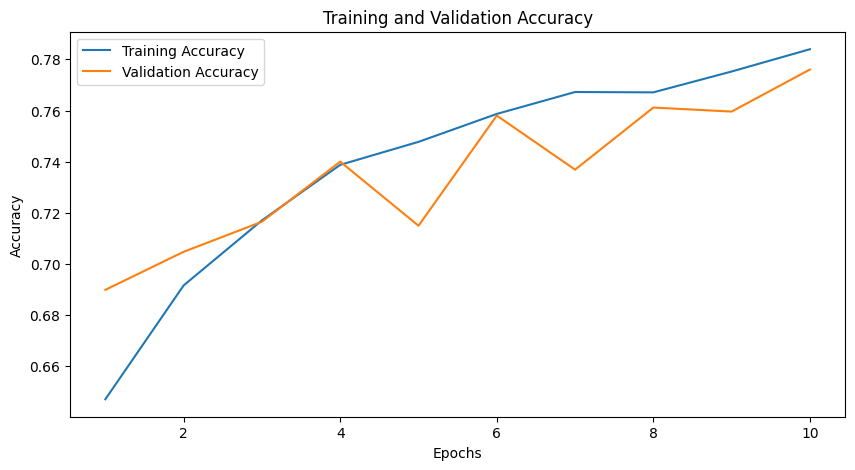

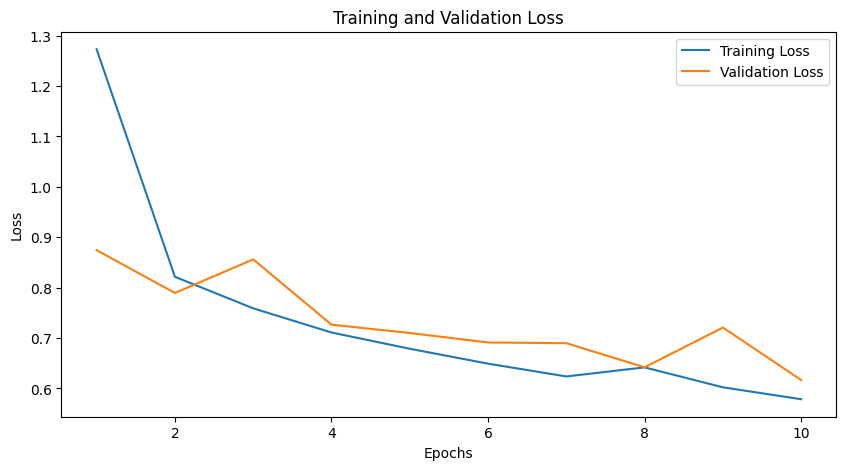

In [ ]:
model5 = EnsembleModel_S(num_classes)

# Compile the Model
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

# Train the model
model5_history = model5.fit(train_generator,
                            validation_data=validate_generator,
                            epochs=epochs,
                            class_weight=class_weight_dict)

# Save the Trained Model
model5.save("ensemble_model_s.h5")

# Evaluate on Test Data
test_loss, test_accuracy = model5.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(model5_history)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.6531 - loss: 1.1830 - val_accuracy: 0.6695 - val_loss: 1.1304
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6708 - loss: 1.1356 - val_accuracy: 0.6695 - val_loss: 1.1380
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.6687 - loss: 1.1458 - val_accuracy: 0.6703 - val_loss: 1.1271
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6720 - loss: 1.1262 - val_accuracy: 0.6688 - val_loss: 1.1365
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6726 - loss: 1.1064 - val_accuracy: 0.6695 - val_loss: 1.0872
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.6664 - loss: 1.1110 - val_accuracy: 0.6688 - val_loss: 1.0831
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6795 - loss: 1.0672 - val_accuracy: 0.6695 - val_loss: 1.1160
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.6741 - loss: 1.0960 -

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.6734 - loss: 1.0609
Test Loss: 1.0711, Test Accuracy: 0.6640


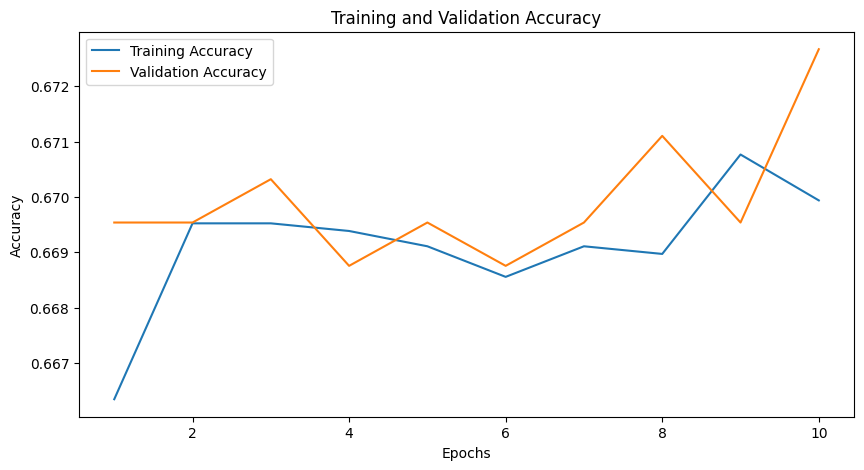

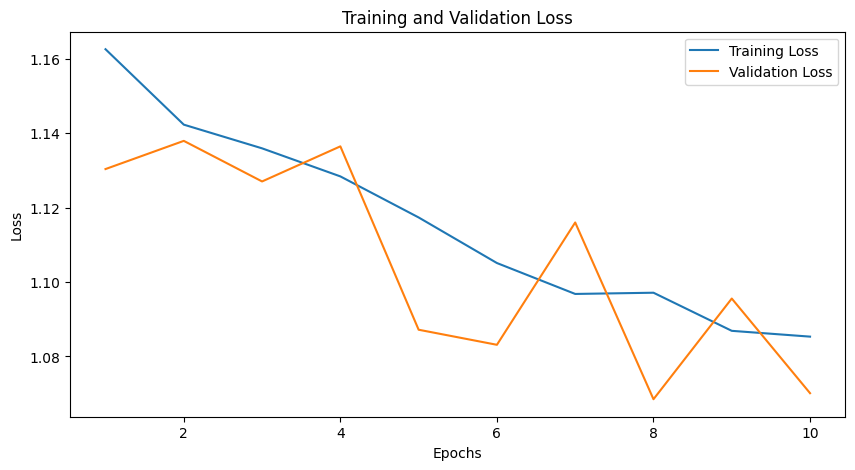

In [ ]:
model6 = UNet_S(num_classes)

# Compile the Model
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

# Train the model
model6_history = model6.fit(train_generator,
                            validation_data=validate_generator,
                            epochs=epochs,
                            class_weight=class_weight_dict)

# Save the Trained Model
model6.save("unet_s.h5")

# Evaluate on Test Data
test_loss, test_accuracy = model6.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(model6_history)

#### Observations for UNet with Classifier
- **Training and Validation Accuracy**: The training and validation accuracy plateaued around 66-67% early in training.
This suggests that the UNet with classifier struggled to effectively learn from the HAM10000 dataset.
- **Loss Plateau**: Both training and validation loss show early plateau, indicating that the model might have reached its learning capacity given the current architecture and dataset.
- **No Overfitting**: The absence of overfitting suggests that the model is underutilizing its capacity or is not well-suited for the classification task, despite having a deep encoder-decoder architecture.

#### Possible Reasons of Poor Performance
- **Designed for Segmentation**: The UNet architecture is primarily designed for segmentation tasks, where pixel-wise predictions are required. While modified for classification, the UNet might not be as efficient for this purpose compared to other architectures.
- **Overparameterization**: The deep encoder-decoder structure of UNet introduces a large number of parameters, which might not be fully utilized for a classification task. This can make learning suboptimal, especially on a moderately sized dataset like HAM10000.

#### Advantages of Baseline CNN and Ensemble Model
Baseline CNN:
- **Simplicity**: The simpler architecture of the Baseline CNN ensures fewer parameters, making it more suitable for moderately sized datasets like HAM10000.
- **Stable Performance**: The Baseline CNN has shown consistent performance, with reasonable training and validation accuracy.
- **Better Generalization**: Due to its simplicity, the Baseline CNN is less prone to overfitting compared to deeper architectures like UNet.

Ensemble Model:
- **Combines Strengths**: The Ensemble model leverages features from two powerful architectures (EfficientNetB0 and DenseNet121), combining their strengths for improved feature representation.
- **Higher Accuracy Potential**: By integrating pretrained features (even partially), the Ensemble model has a higher potential for achieving better accuracy compared to individual models.

> Based on these observations, we will proceed with the Baseline CNN and Ensemble Model for the following reasons:

- **UNet's Underperformance**: The UNet classifier struggled to effectively learn from the HAM10000 dataset, possibly due to its design being better suited for segmentation tasks.
- **Baseline CNN's Simplicity**: The Baseline CNN offers a straightforward architecture with stable performance and generalization.
- **Ensemble Model's Versatility**: The Ensemble model combines powerful feature extraction with flexibility, offering the best potential for improved accuracy.

_______


|Model|Testing Acc (%)|Testing Loss|
|:-:|:-:|:-:|
|Pretrained ensemble model|73 - 75|0.6528|
|Non-pretrained ensemble model|78|0.6180|

The results of Ensemble Model demonstrate that using pretrained models with ImageNet weights did not improve accuracy. In contrast, training the models from scratch yielded better performance. This discrepancy could be attributed to the mismatch between the features learned from ImageNet (a dataset of natural images) and the specific requirements of the HAM10000 medical dataset.

Given these results, we have chosen to proceed with training the models from scratch for the following reasons:

1. **Better Suitability for the Dataset**: Pretrained weights from ImageNet may not generalize well to the HAM10000 dataset, which consists of specialized medical images that differ significantly from the natural images in ImageNet.
2. **Improved Accuracy**: Training the models from scratch enables the network to learn features specifically tailored to the HAM10000 dataset, leading to better performance compared to models relying on pretrained weights.

While pretrained models often provide advantages such as faster convergence and reduced risk of overfitting, the unique characteristics of the HAM10000 dataset suggest that training from scratch is more appropriate in this scenario.

However, training large neural networks from scratch on a moderate-sized dataset like HAM10000 poses a higher potential risk of overfitting. To mitigate this, careful attention must be given to regularization techniques such as dropout, data augmentation, and early stopping, ensuring the model generalizes effectively to unseen data.

### Model Tuning

To maximize the model performance while reducing overfitting, we will try to:

*   For Baseline CNN, increase the convolutional layer for improved feature discrimination and increase dense units improved decision boundaries
*   Implement dropout layer
*   Use grid search to find best hyperparameters: batch size, optimizer, activation function, dropout rate
*   Start with the common learning rate: 0.001 and use a learning rate scheduler
*   Train with more epoch: 50 and implement early stopping
*   Address class imbalance issue using class weight

Data preparation and preprocessing steps done:
*   Standardization
*   One hot encoded cz suit output of neural network (use Categorical cross entropy cz one hot encoded is used)
*   Data augmentation
*   Stratified data splitting





In [ ]:
# Hyperparameter grid search
def create_model(num_classes, activation_function, dropout_rate):
    # Determine activation function
    if activation_function == 'relu':
        activation = 'relu'
    elif activation_function == 'leaky_relu':
        activation = LeakyReLU()

    # Define model
    model = tf.keras.Sequential([
        # Feature extractor
        tf.keras.Input(shape=(75, 100, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(32, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Dropout(dropout_rate),

        # Classifier
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


# Define Grid Search
batch_sizes = [32, 64]
optimizers = {'Adam': tf.keras.optimizers.Adam,
              'NAdam': tf.keras.optimizers.Nadam}
activation_functions = ['relu', 'leaky_relu']
dropout_rates = [0.2, 0.5]

def grid_search(train_generator, validate_generator, num_classes):
    best_val_accuracy = 0
    best_params = {}

    for batch_size in batch_sizes:
        for opt_name, opt_func in optimizers.items():
            for activation_function in activation_functions:
                for dropout_rate in dropout_rates:
                    print(f"Testing: Batch Size={batch_size}, Optimizer={opt_name}, Activation={activation_function}, Dropout={dropout_rate}")

                    # Create model
                    model = create_model(num_classes, activation_function, dropout_rate)

                    # Compile model
                    optimizer = opt_func()
                    model.compile(optimizer=optimizer,
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

                    # Train model
                    history = model.fit(train_generator,
                                        validation_data=validate_generator,
                                        epochs=5,
                                        class_weight=class_weight_dict)

                    # Evaluate on validation set
                    val_accuracy = history.history['val_accuracy'][-1]

                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_params = {
                            'batch_size': batch_size,
                            'optimizer': opt_name,
                            'activation_function': activation_function,
                            'dropout_rate': dropout_rate}

    print("Best Parameters:", best_params)
    print("Best Validation Accuracy:", best_val_accuracy)
    return best_params

In [ ]:
# Run Grid Search
best_params_baseline = grid_search(train_generator, validate_generator, num_classes)

### Model Evaluation

The best parameters found by grid search:
- batch_size: 64
- optimizer: NAdam
- activation_function: leaky_relu
- dropout_rate: 0.2

Now, we will train with higher epoch and compare the Baseline CNN with Enhanced CNN and the Ensemble Model.

In [ ]:
epochs = 50

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              min_lr=0.0001)

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.6496 - loss: 1.3169 - val_accuracy: 0.6922 - val_loss: 0.8657 - learning_rate: 0.0010
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.7044 - loss: 0.8202 - val_accuracy: 0.7071 - val_loss: 0.7938 - learning_rate: 0.0010
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7143 - loss: 0.7861 - val_accuracy: 0.7384 - val_loss: 0.7296 - learning_rate: 0.0010
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7400 - loss: 0.7361 - val_accuracy: 0.7416 - val_loss: 0.7278 - learning_rate: 0.0010
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7462 - loss: 0.7149 - val_accuracy: 0.7424 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7470 - loss: 0.6798 - val_accuracy: 0.7666 - val_loss: 0.6785 - learning_rate: 0.0010
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7517 - l

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7675 - loss: 0.6235
Test Loss: 0.5987, Test Accuracy: 0.7771


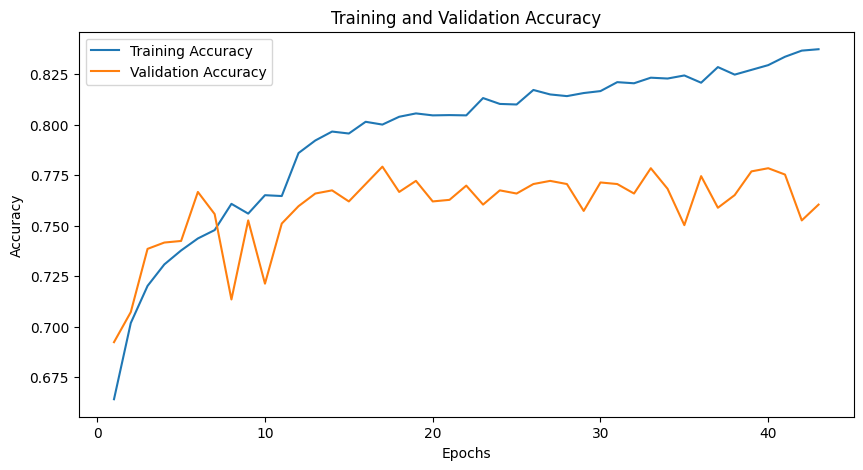

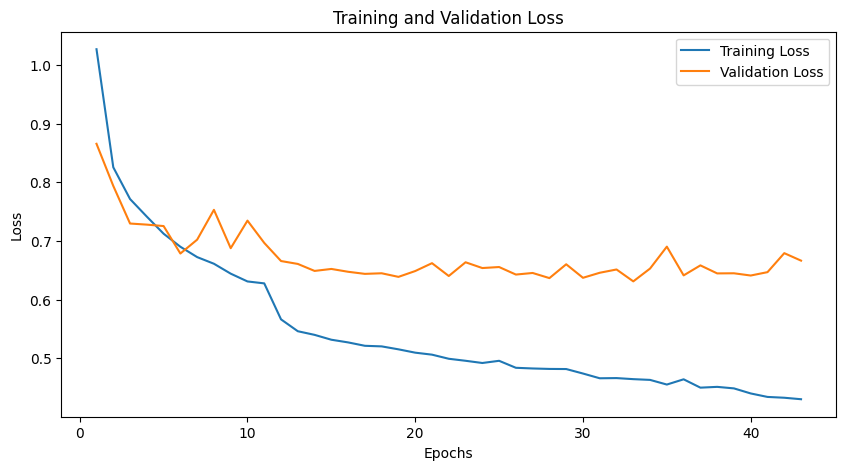

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 0.7771
Precision: 0.7664
Recall: 0.7771
F1 Score: 0.7690
False Negative Rate (FNR): 0.2229
AUC: 0.9428

Classification Report:
                               precision    recall  f1-score   support

             Melanocytic nevi       0.45      0.31      0.37        49
                     Melanoma       0.59      0.61      0.60        77
Benign keratosis-like lesions       0.53      0.58      0.55       165
         Basal cell carcinoma       0.50      0.24      0.32        17
            Actinic keratoses       0.88      0.92      0.90      1006
             Vascular lesions       0.53      0.42      0.47       167
               Dermatofibroma       0.86      0.55      0.67        22

                     accuracy                           0.78      1503
                    macro avg       0.62      0.52      0.55      1503
                 weighted avg       0.77      0.78      0.77      1503



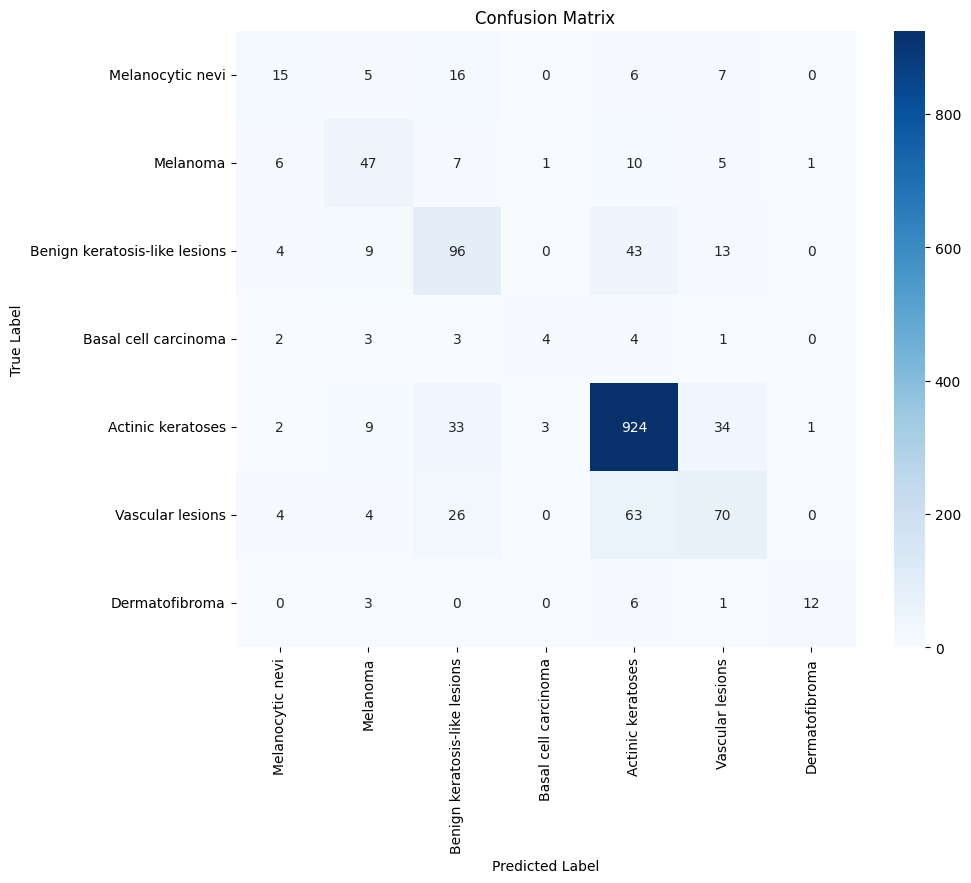

In [ ]:
# Train the Baseline CNN using the initial parameters configuration with 50 epoch
model = BaselineCNN(num_classes)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
model_history = model.fit(train_generator,
                          validation_data=validate_generator,
                          epochs=epochs,
                          callbacks=[early_stopping, reduce_lr],
                          class_weight=class_weight_dict)

# Save the Trained Model
model.save("baseline_cnn_final.h5")

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(model_history)

# Print Classification Report and Confusion Matrix
evaluate_model(model, x_test, y_test)

In [ ]:
batch_size = 64
dropout_rate = 0.2
input_tensor = tf.random.normal((batch_size, 75, 100, 3))
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
validate_generator = validate_datagen.flow(x_validate, y_validate, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(Model):
    def __init__(self, num_classes, dropout_rate=dropout_rate):
        super(CNN, self).__init__()
        self.features = tf.keras.Sequential([
           # First Conv Block
            layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding='same'),
            layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Second Conv Block
            layers.Conv2D(64, (3, 3), activation=LeakyReLU(), padding='same'),
            layers.Conv2D(64, (3, 3), activation=LeakyReLU(), padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Third Conv Block
            layers.Conv2D(128, (3, 3), activation=LeakyReLU(), padding='same'),
            layers.Conv2D(128, (3, 3), activation=LeakyReLU(), padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Regularization
            layers.Dropout(dropout_rate)
        ])
        self.flatten = layers.Flatten()
        self.classifier = tf.keras.Sequential([
            layers.Dense(512, activation=LeakyReLU()),  # Adjusted Dense Layer Size
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        x = self.features(inputs)
        x = self.flatten(x)
        return self.classifier(x)

class EnsembleModel(Model):
    def __init__(self, num_classes, dropout_rate=dropout_rate):
        super(EnsembleModel, self).__init__()
        # Pretrained EfficientNetB0
        self.efficientnet = EfficientNetB0(include_top=False, pooling='avg', input_shape=(75, 100, 3))

        # Pretrained DenseNet121
        self.densenet = DenseNet121(include_top=False, pooling='avg', input_shape=(75, 100, 3))

        # Classifier layers
        self.classifier = tf.keras.Sequential([
            layers.Dense(512, activation=LeakyReLU()),
            layers.Dropout(dropout_rate),  # Dropout for regularization
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        # Forward pass through the encoders
        x1 = self.efficientnet(inputs)
        x2 = self.densenet(inputs)

        # Concatenate features and classify
        x = tf.concat([x1, x2], axis=-1)
        return self.classifier(x)


# CNN
cnn_model = CNN(num_classes)
cnn_output = cnn_model(input_tensor)

# Ensemble Model
ensemble_model = EnsembleModel(num_classes)
ensemble_model_output = ensemble_model(input_tensor)

print(cnn_output.shape, ensemble_model_output.shape)

(64, 7) (64, 7)


In [ ]:
print(cnn_model.summary())
print(ensemble_model.summary())

Model: "cnn_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_144 (Sequential)          │ (64, 9, 12, 128)            │         287,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_53 (Flatten)                 │ (64, 13824)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_145 (Sequential)          │ (64, 7)                     │       7,084,039 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,371,943 (28.12 MB)

 Trainable params: 7,370,471 (28.12 MB)

 Non-trainable params: 1,472 (5.75 KB)

None


Model: "ensemble_model_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_146 (Sequential)          │ (64, 7)                     │       1,183,751 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,270,826 (46.81 MB)

 Trainable params: 12,145,155 (46.33 MB)

 Non-trainable params: 125,671 (490.91 KB)

None


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.6230 - loss: 1.1840 - val_accuracy: 0.7134 - val_loss: 0.8063 - learning_rate: 0.0010
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.7022 - loss: 0.8056 - val_accuracy: 0.7126 - val_loss: 0.8279 - learning_rate: 0.0010
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.7166 - loss: 0.7802 - val_accuracy: 0.7471 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.7341 - loss: 0.7120 - val_accuracy: 0.7478 - val_loss: 0.7405 - learning_rate: 0.0010
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.7438 - loss: 0.7039 - val_accuracy: 0.7518 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 0.6959 - loss: 0.9121 - val_accuracy: 0.7369 - val_loss: 0.7211 - learning_rate: 0.0010
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.7313 - loss:

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7845 - loss: 0.5614
Test Loss: 0.5446, Test Accuracy: 0.7937


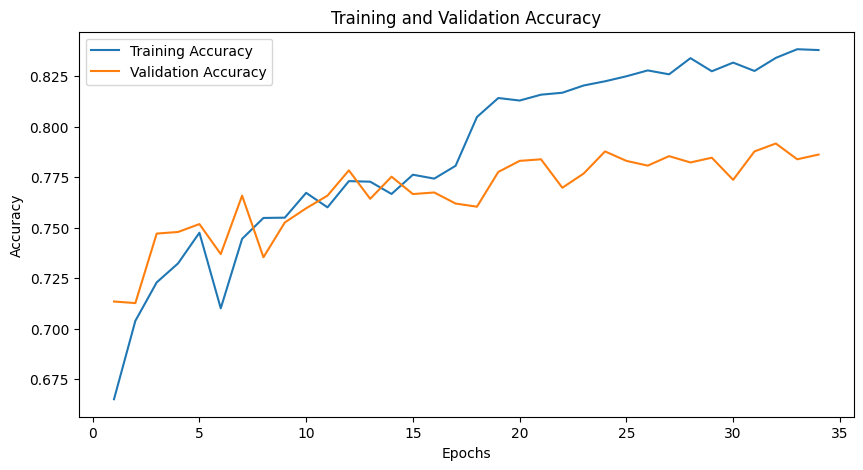

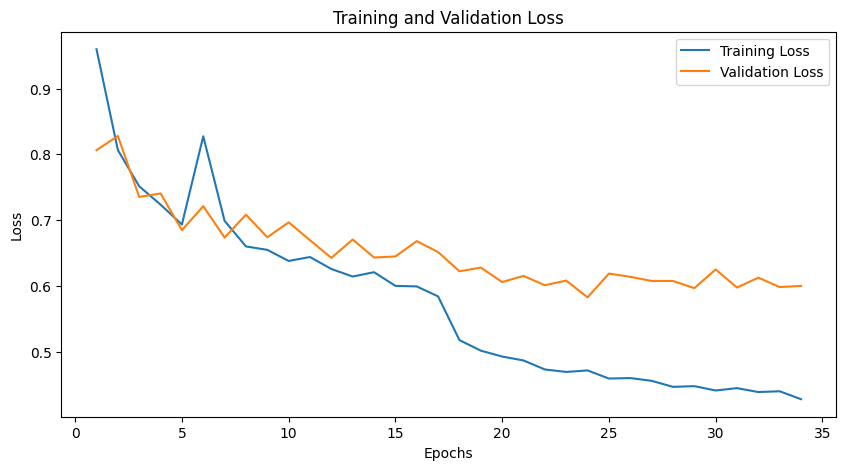

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.7937
Precision: 0.7814
Recall: 0.7937
F1 Score: 0.7850
False Negative Rate (FNR): 0.2063
AUC: 0.9521

Classification Report:
                               precision    recall  f1-score   support

             Melanocytic nevi       0.59      0.59      0.59        49
                     Melanoma       0.63      0.65      0.64        77
Benign keratosis-like lesions       0.59      0.54      0.56       165
         Basal cell carcinoma       0.75      0.71      0.73        17
            Actinic keratoses       0.87      0.93      0.90      1006
             Vascular lesions       0.52      0.38      0.44       167
               Dermatofibroma       0.92      0.55      0.69        22

                     accuracy                           0.79      1503
                    macro avg       0.70      0.62      0.65      1503
                 weighted avg       0.78      0.79      0.79      1503



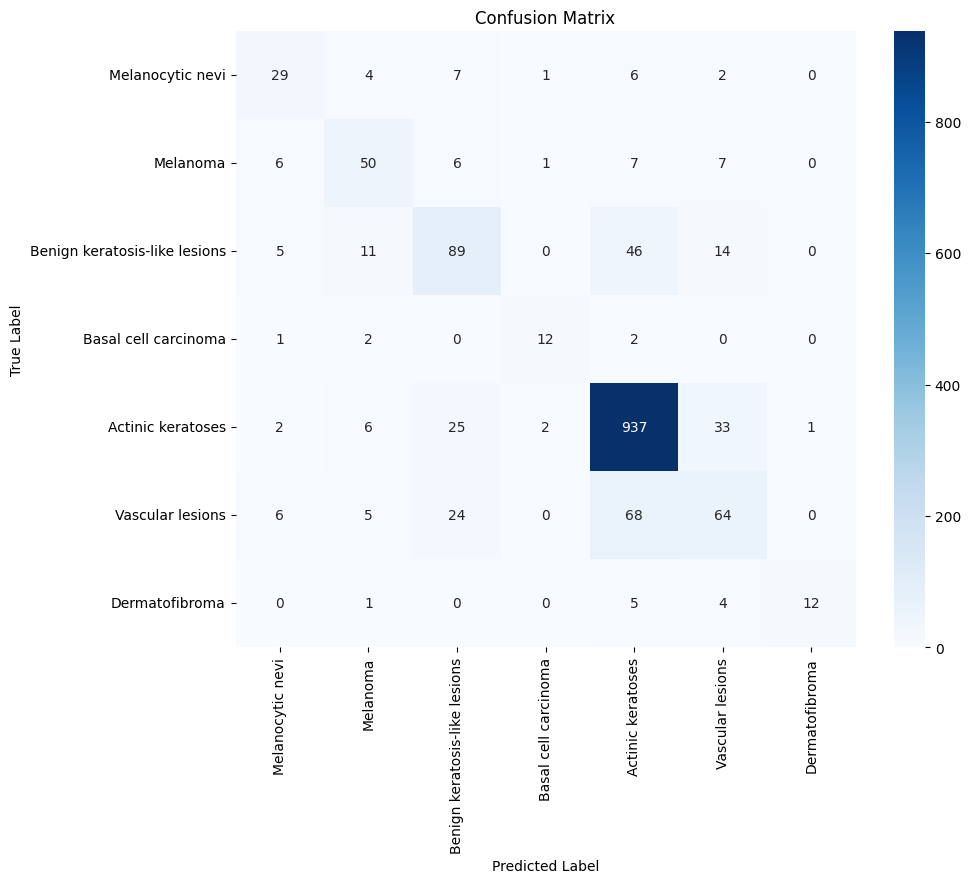

In [ ]:
# CNN
cnn = CNN(num_classes)

# Compile the Model
cnn.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# Train the model
cnn_history = cnn.fit(train_generator,
                      validation_data=validate_generator,
                      epochs=epochs,
                      callbacks=[early_stopping, reduce_lr],
                      class_weight=class_weight_dict)

# Save the Trained Model
cnn.save("cnn_final.h5")

# Evaluate on Test Data
test_loss, test_accuracy = cnn.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(cnn_history)

# Print Classification Report and Confusion Matrix
evaluate_model(cnn, x_test, y_test)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 232s 779ms/step - accuracy: 0.5526 - loss: 2.4139 - val_accuracy: 0.6460 - val_loss: 0.8909 - learning_rate: 0.0010
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.6912 - loss: 0.8254 - val_accuracy: 0.6860 - val_loss: 0.8040 - learning_rate: 0.0010
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.7195 - loss: 0.7430 - val_accuracy: 0.7220 - val_loss: 0.7692 - learning_rate: 0.0010
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.7307 - loss: 0.7273 - val_accuracy: 0.7674 - val_loss: 0.6608 - learning_rate: 0.0010
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.7629 - loss: 0.6453 - val_accuracy: 0.7533 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.7536 - loss: 0.6781 - val_accuracy: 0.7455 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.8192 - loss: 0.5060
Test Loss: 0.5026, Test Accuracy: 0.8230


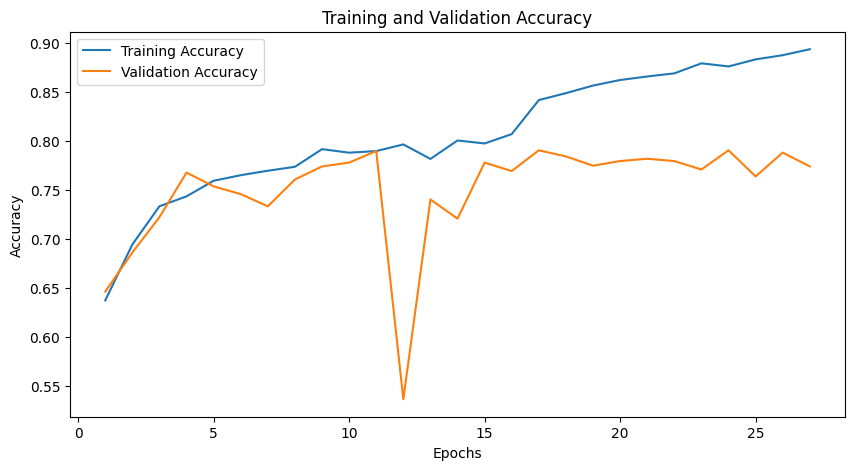

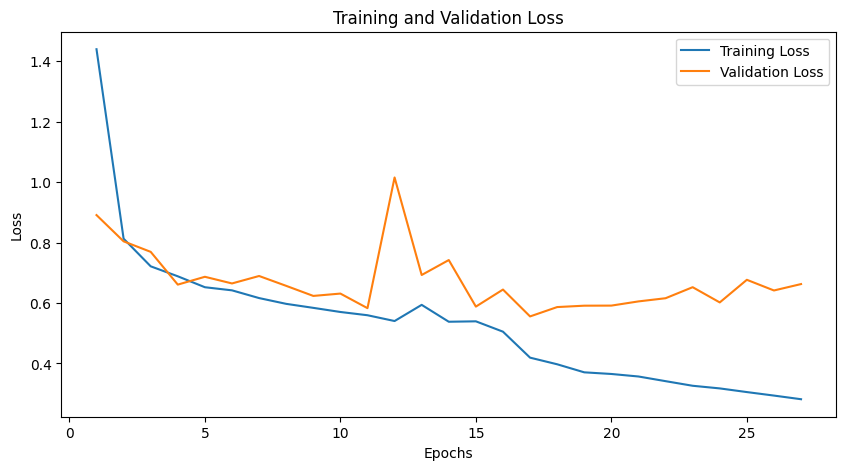

47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step
Accuracy: 0.8230
Precision: 0.8148
Recall: 0.8230
F1 Score: 0.8162
False Negative Rate (FNR): 0.1770
AUC: 0.9584

Classification Report:
                               precision    recall  f1-score   support

             Melanocytic nevi       0.56      0.67      0.61        49
                     Melanoma       0.70      0.65      0.68        77
Benign keratosis-like lesions       0.63      0.59      0.61       165
         Basal cell carcinoma       0.62      0.47      0.53        17
            Actinic keratoses       0.90      0.95      0.92      1006
             Vascular lesions       0.65      0.48      0.55       167
               Dermatofibroma       0.93      0.64      0.76        22

                     accuracy                           0.82      1503
                    macro avg       0.71      0.64      0.67      1503
                 weighted avg       0.81      0.82      0.82      1503



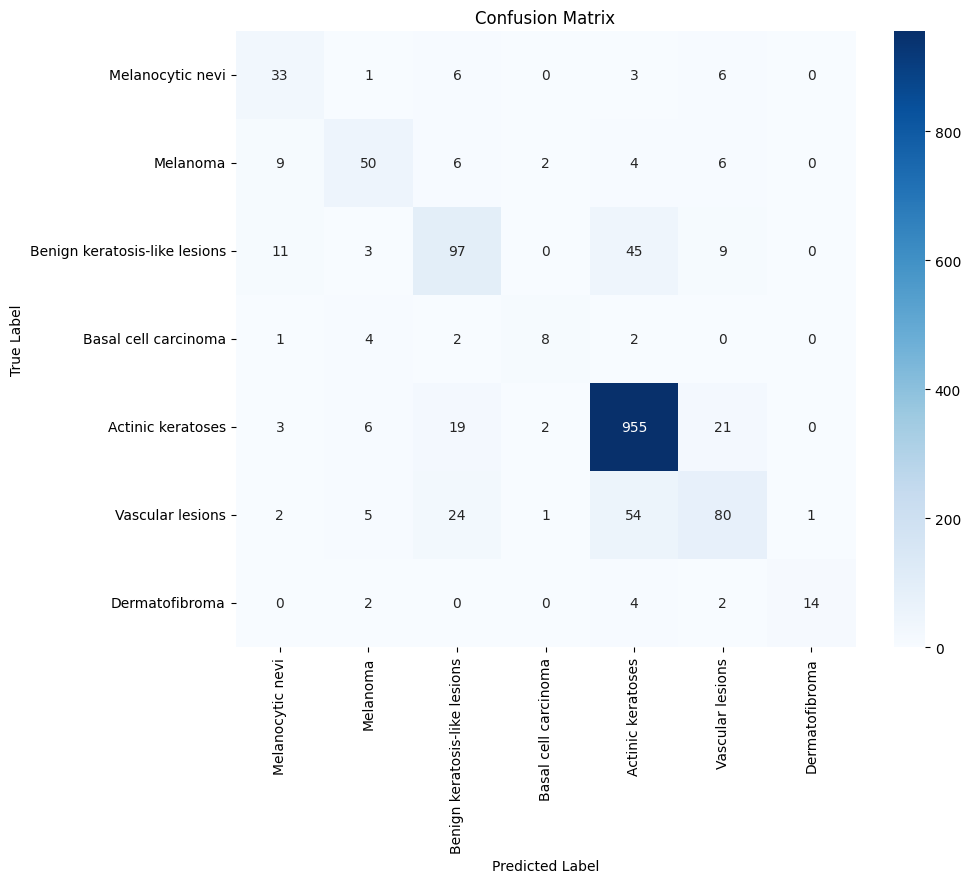

In [ ]:
# Ensemble
ensemble = EnsembleModel(num_classes)

# Compile the Model
ensemble.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
                 loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])

# Train the model
ensemble_history = ensemble.fit(train_generator,
                                validation_data=validate_generator,
                                epochs=epochs,
                                callbacks=[early_stopping, reduce_lr],
                                class_weight=class_weight_dict)

# Save the Trained Model
ensemble.save("ensemble_final.h5")

# Evaluate on Test Data
test_loss, test_accuracy = ensemble.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot model training history
plot_history(ensemble_history)

# Print Classification Report and Confusion Matrix
evaluate_model(ensemble, x_test, y_test)

# END